# External model tutorial

In this tutorial you will learn the basics of the model interface for running an external model. The API for the model interface is provided here:

https://pressio.github.io/rom-tools-and-workflows/romtools/workflows/models.html


In [1]:
#First, let's import the relavant modules:
import romtools
import numpy as np
from matplotlib import pyplot as plt
from romtools.workflows import models
import os

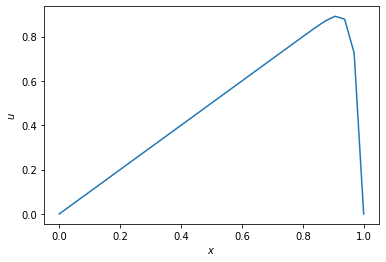

In [2]:
'''
Here, we will interface around a model for solving the 1D advection diffusion problem.
The model code is given in adr_1d/adr_1d.py, and it solves the 1d advection diffusion equation:

c u_x - nu * u_xx = 1


To run the code, a file "params.dat" is required in the run directory. 
This .dat file contains the parameters c,nu. 
Running the code outputs a solution.npz file with the keys x (grid) and u (solution)

'''

# Here is an example of how we would run the code
if __name__ == "__main__":
    #First, let's create our parameters
    c = 1.
    nu = 1.e-2
    #Now, we will save them to a file expected by the adr_1d.py code
    np.savetxt('params.dat',np.array([c,nu]))

    #This is how we would execute our external code
    #(For a more sophisticated application, this is likely an mpi call to an executable or
    # a submission to the HPCs)
    os.system('python adr_1d/adr_1d.py')

    #Let's take a peak at a solution
    sol = np.load('solution.npz')
    plt.plot(sol['x'],sol['u'])
    plt.xlabel(r'$x$')
    plt.ylabel(r'$u$')

    # Now we will clean up the files we created
    os.system('rm params.dat')
    os.system('rm solution.npz')

In [3]:
## Now, let's create a romtools wrapper around this model that meets the API of the ModelClass
class adrExternalRomToolsModel:
    def __init__(self):
        # Get path to adr code
        self.exec_dir_ = os.getcwd() + '/adr_1d/'
        
    def populate_run_directory(self, run_directory: str, parameter_sample: dict):
        # Here, we need to make a params.dat file in the run_directory
        c = parameter_sample['c']
        nu = parameter_sample['nu']
        np.savetxt(run_directory + '/params.dat',np.array([c,nu]))
        
    def run_model(self, run_directory: str, parameter_sample: dict):
        starting_dir = os.getcwd()
        os.chdir(run_directory)
        os.system('python ' + self.exec_dir_ + 'adr_1d.py')
        #To avoid confusion, we will move back to the directory we started from
        os.chdir(starting_dir)
        return 0

#Now let's try initializing the model
adr_for_romtools = adrExternalRomToolsModel()

#That's it, we can use this in a sampling workflow. 

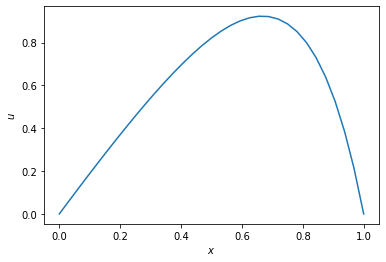

In [4]:
#Let's do an example run of the model similar to how it will be used in a workflow.


if __name__ == "__main__":
    #Initialize the model
    adr_for_romtools = adrExternalRomToolsModel()

    #First, let's make a dictionary that is a stand in for the parameter space
    parameter_sample = {}
    parameter_sample['c'] = 0.5
    parameter_sample['nu'] = 1e-1
    
    #Now, let's populate our run directory. In this example, we will just use the current run directory.
    #In a full workflow, romtools will manage creating directories
    adr_for_romtools.populate_run_directory(os.getcwd(),parameter_sample)
    
    #Now, let's run the model
    adr_for_romtools.run_model(os.getcwd(),parameter_sample)

    #We can look at a solution
    sol = np.load('solution.npz')
    plt.plot(sol['x'],sol['u'])
    plt.xlabel(r'$x$')
    plt.ylabel(r'$u$')

    #We will finish by cleaning up the files we created
    os.system('rm params.dat')
    os.system('rm solution.npz')

    #That's it! See the sampling tutorial for an example of how this model is used in a sampling workflow